<a href="https://colab.research.google.com/github/Revant-1/Fashion-AI/blob/main/fashionAiV1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving strip-shirt.jpg to strip-shirt.jpg


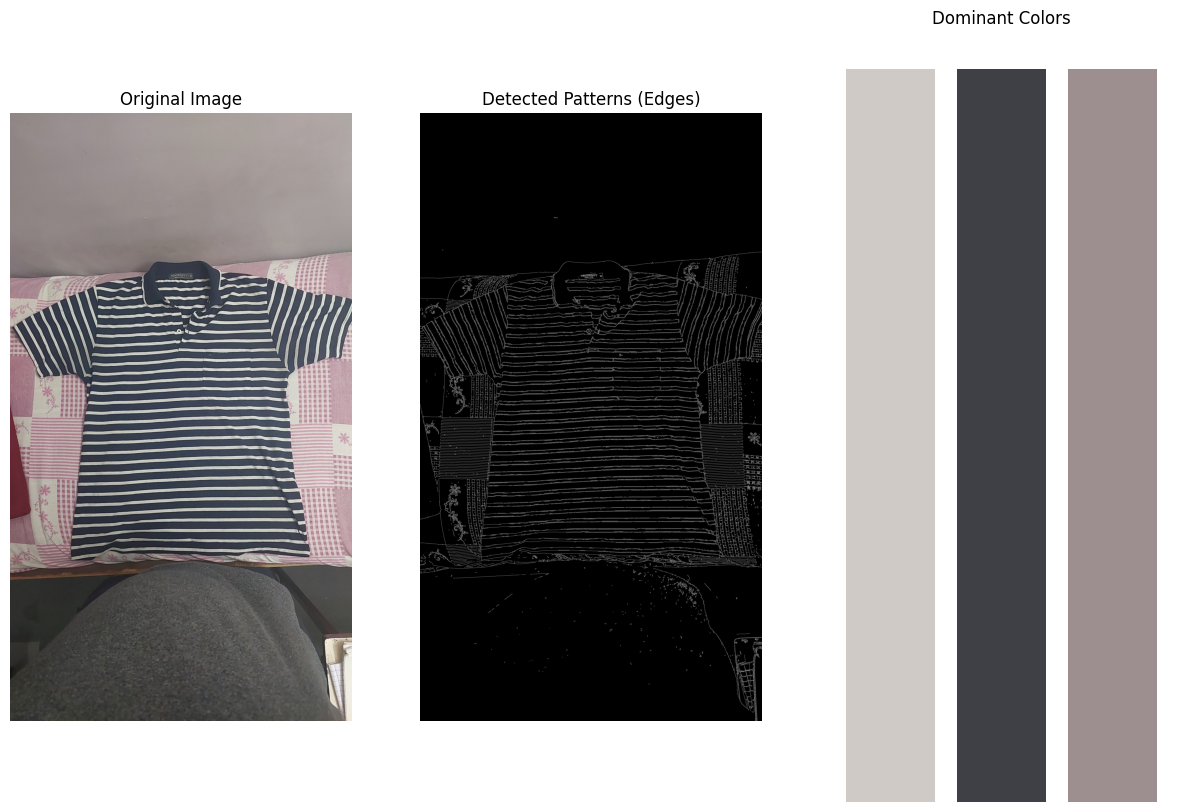

HOG Features Extracted: 502324200


In [ ]:
# Install necessary libraries
!pip install opencv-python-headless numpy matplotlib pillow

# Import libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from PIL import Image

# Upload and load the image
from google.colab import files
uploaded = files.upload()

image_path = list(uploaded.keys())[0]
image = cv2.imread(image_path)

# Function to detect patterns
def detect_patterns(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    return edges

# Function to detect dominant colors
def detect_colors(image, k=3):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img = img.reshape((-1, 3))
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(img)
    colors = kmeans.cluster_centers_.astype(int)
    return colors

# Function to extract features using HOG
def extract_hog_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hog = cv2.HOGDescriptor()
    features = hog.compute(gray)
    return features

# Detect patterns
patterns = detect_patterns(image)

# Detect colors
colors = detect_colors(image)

# Extract HOG features
hog_features = extract_hog_features(image)

# Display results
plt.figure(figsize=(15, 10))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

# Pattern detection
plt.subplot(1, 3, 2)
plt.imshow(patterns, cmap="gray")
plt.title("Detected Patterns (Edges)")
plt.axis("off")

# Display dominant colors
plt.subplot(1, 3, 3)
plt.title("Dominant Colors")
for i, color in enumerate(colors):
    plt.bar(i, 1, color=color/255)
plt.axis("off")
plt.show()

# Display HOG features size
print(f"HOG Features Extracted: {len(hog_features)}")


In [3]:
# First cell - Install dependencies
!pip install opencv-python-headless numpy matplotlib pillow requests sklearn
!wget https://pjreddie.com/media/files/yolov3.weights
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg

# Second cell - Import libraries and define the class
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from PIL import Image
import requests
from pathlib import Path
from google.colab import files
from IPython.display import display, clear_output

class ClothingAnalyzer:
    def __init__(self):
        # Initialize YOLO network
        self.weights_path = "yolov3.weights"
        self.config_path = "yolov3.cfg"
        self.net = cv2.dnn.readNetFromDarknet(self.config_path, self.weights_path)
        self.layer_names = self.net.getLayerNames()
        self.output_layers = [self.layer_names[i - 1] for i in self.net.getUnconnectedOutLayers()]

        # Clothing-related COCO classes
        self.clothing_classes = ['person', 'tie', 'backpack', 'umbrella', 'handbag',
                               'suitcase', 'sports ball', 'tennis racket']

    def detect_clothes(self, image):
        height, width = image.shape[:2]

        # Prepare image for YOLO
        blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416), swapRB=True, crop=False)
        self.net.setInput(blob)
        outs = self.net.forward(self.output_layers)

        boxes = []
        confidences = []
        class_ids = []

        # Process detections
        for out in outs:
            for detection in out:
                scores = detection[5:]
                class_id = np.argmax(scores)
                confidence = scores[class_id]

                if confidence > 0.5 and str(class_id) in self.clothing_classes:
                    center_x = int(detection[0] * width)
                    center_y = int(detection[1] * height)
                    w = int(detection[2] * width)
                    h = int(detection[3] * height)

                    x = int(center_x - w/2)
                    y = int(center_y - h/2)

                    boxes.append([x, y, w, h])
                    confidences.append(float(confidence))
                    class_ids.append(class_id)

        indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
        return [boxes[i] for i in indices]

    def detect_patterns(self, roi):
        gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

        # Apply Gabor filter
        ksize = 31
        sigma = 5
        theta = 0
        lambd = 10
        gamma = 0.5
        kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma)
        filtered = cv2.filter2D(gray, cv2.CV_8UC3, kernel)

        edges = cv2.Canny(filtered, 50, 150)
        return edges

    def detect_colors(self, roi, k=3):
        rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
        pixels = rgb.reshape(-1, 3)

        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(pixels)

        colors = kmeans.cluster_centers_.astype(int)
        percentages = np.bincount(kmeans.labels_) / len(kmeans.labels_)

        return colors, percentages

    def analyze_image(self, image):
        clothes_boxes = self.detect_clothes(image)

        results = []
        for box in clothes_boxes:
            x, y, w, h = box
            # Ensure coordinates are within image boundaries
            x = max(0, x)
            y = max(0, y)
            w = min(w, image.shape[1] - x)
            h = min(h, image.shape[0] - y)

            roi = image[y:y+h, x:x+w]

            if roi.size == 0:
                continue

            patterns = self.detect_patterns(roi)
            colors, percentages = self.detect_colors(roi)

            results.append({
                'roi': roi,
                'patterns': patterns,
                'colors': colors,
                'color_percentages': percentages
            })

        return results

    def visualize_results(self, image, results):
        plt.figure(figsize=(20, 5 * (len(results) + 1)))

        # Show original image
        plt.subplot(len(results) + 1, 3, 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title("Original Image")
        plt.axis("off")

        for i, result in enumerate(results):
            base_idx = (i + 1) * 3

            # Show ROI
            plt.subplot(len(results) + 1, 3, base_idx + 1)
            plt.imshow(cv2.cvtColor(result['roi'], cv2.COLOR_BGR2RGB))
            plt.title(f"Detected Clothing {i+1}")
            plt.axis("off")

            # Show patterns
            plt.subplot(len(results) + 1, 3, base_idx + 2)
            plt.imshow(result['patterns'], cmap='gray')
            plt.title(f"Patterns {i+1}")
            plt.axis("off")

            # Show color distribution
            plt.subplot(len(results) + 1, 3, base_idx + 3)
            for j, (color, percentage) in enumerate(zip(result['colors'], result['color_percentages'])):
                plt.bar(j, percentage, color=color/255)
            plt.title(f"Color Distribution {i+1}")
            plt.axis("off")

        plt.tight_layout()
        plt.show()

# Third cell - Run the analysis
def analyze_clothing():
    print("Please upload an image...")
    uploaded = files.upload()

    if not uploaded:
        print("No image uploaded!")
        return

    image_path = list(uploaded.keys())[0]
    image = cv2.imread(image_path)

    if image is None:
        print("Could not read the image!")
        return

    analyzer = ClothingAnalyzer()
    results = analyzer.analyze_image(image)

    if not results:
        print("No clothing items detected in the image!")
        return

    print(f"Found {len(results)} clothing items!")
    analyzer.visualize_results(image, results)

# Run the analysis
analyze_clothing()

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
--2025-01-22 04:40:08--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights.2’

yolov3.weights.2    100%[===================>] 236.52M  12.1MB/s    in 18s     

2025-01-22 04:40:27 (13.1 MB/s) - ‘yolov3.weights.2’ 

Saving image.jpg to image.jpg
No clothing items detected in the image!


Saving image.jpg to image (1).jpg
Original Image:


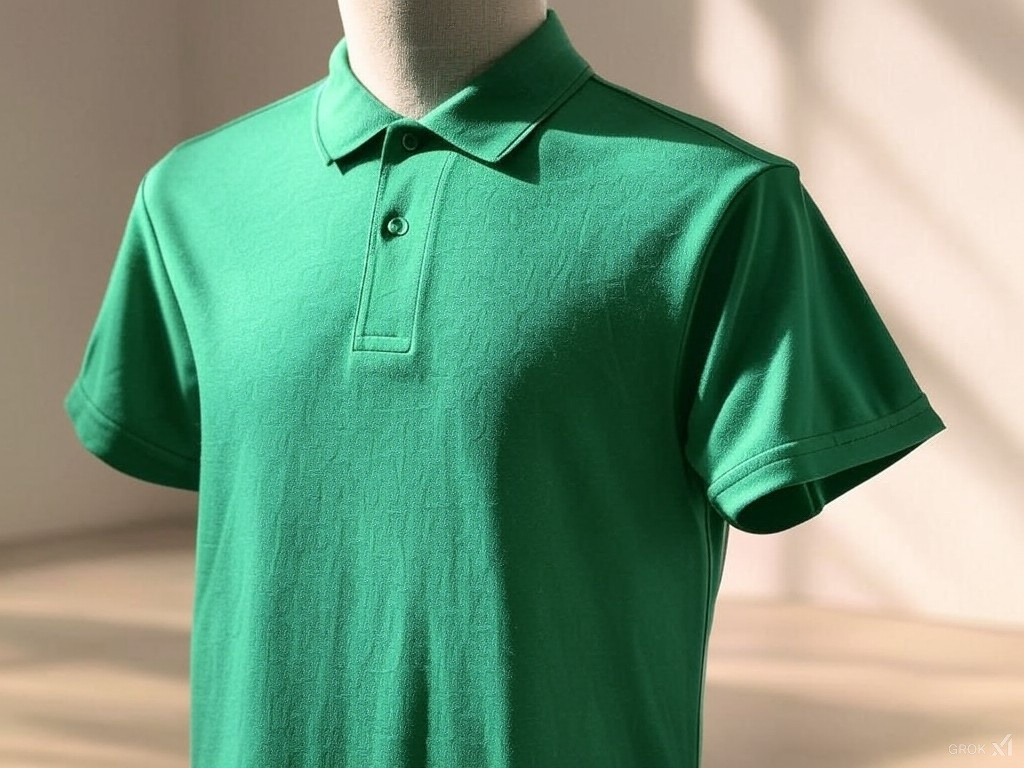

100%|███████████████████████████████████████| 176M/176M [00:00<00:00, 65.1GB/s]


Image Without Background:


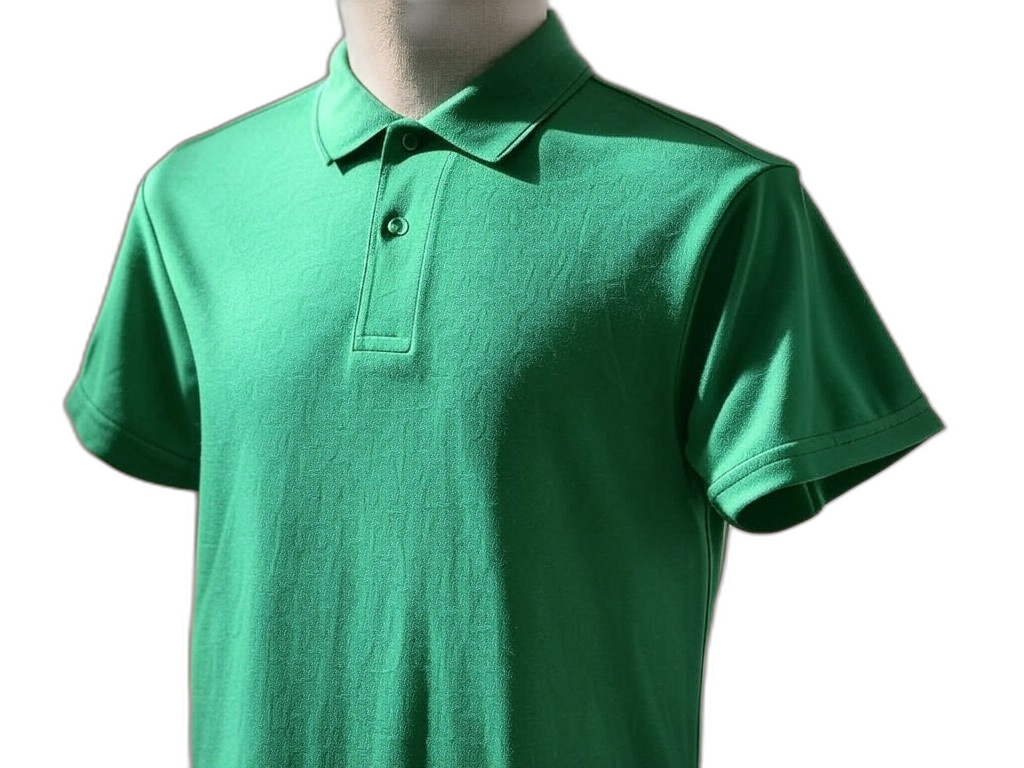

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
# Google Colab Notebook for Removing Background from Images

# Step 1: Install Required Libraries
!pip install rembg onnxruntime Pillow

# Step 2: Import Necessary Libraries
from rembg import remove
from PIL import Image
from io import BytesIO
import IPython.display as display

# Step 3: Upload Your Image
from google.colab import files

uploaded = files.upload()

# Step 4: Load and Display the Uploaded Image
uploaded_filename = list(uploaded.keys())[0]
original_image = Image.open(uploaded_filename)

print("Original Image:")
display.display(original_image)

# Step 5: Remove Background
with open(uploaded_filename, "rb") as image_file:
    input_image_bytes = image_file.read()
    output_image_bytes = remove(input_image_bytes)

# Convert the result to an image format
output_image = Image.open(BytesIO(output_image_bytes))

# Step 6: Save and Display the Result
output_image_filename = "image_without_background.png"
output_image.save(output_image_filename)

print("Image Without Background:")
display.display(output_image)

# Step 7: Download the Result
from google.colab import files
files.download(output_image_filename)
